<a href="https://colab.research.google.com/github/PriyanshuR23/Industrial_IOT_Predictive_Maintenance/blob/main/TabNSA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Datasets/AI4I-PMDI.csv')

print(df.head())

Mounted at /content/drive
   UDI              Date  System Control Product ID Type  Air temperature (K)  \
0    1  15/04/2014 11:56       0       C     M14860    M                  NaN   
1    2  12/04/2014 16:09       0       A     L47181    L                298.2   
2    3  13/04/2014 01:13       0       A     L47182    L                298.1   
3    4  24/07/2014 20:35       0       B     L47183    L                  NaN   
4    5  22/07/2014 01:31       0       C     L47184    L                  NaN   

   Process temperature (K)  Rotational speed (rpm)  Torque (Nm)  \
0                      NaN                     NaN         42.8   
1                    308.7                  1408.0          NaN   
2                    308.5                  1498.0          NaN   
3                      NaN                  1433.0         39.5   
4                      NaN                     NaN         40.0   

   Tool wear (min)  Diagnostic  
0              0.0  No failure  
1              NaN

In [2]:
unique_diagnostics = df['Diagnostic'].unique()
num_unique_diagnostics = len(unique_diagnostics)

print(f"Number of unique diagnostics: {num_unique_diagnostics}")
print(f"Unique diagnostic names: {unique_diagnostics}")

Number of unique diagnostics: 6
Unique diagnostic names: ['No failure' 'Power Failure' 'Overstrain Failure' 'Tool Wear Failure'
 'Random Failures' 'Heat Dissipation Failure']


In [3]:
from IPython.display import display, HTML

display(HTML(df.head().to_html()))

,UDI,Date,System,Control,Product ID,Type,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),Diagnostic
0,1,15/04/2014 11:56,0,C,M14860,M,NaN,NaN,NaN,42.8,0.0,No failure
1,2,12/04/2014 16:09,0,A,L47181,L,298.2,308.7,1408.0,NaN,NaN,No failure
2,3,13/04/2014 01:13,0,A,L47182,L,298.1,308.5,1498.0,NaN,NaN,No failure
3,4,24/07/2014 20:35,0,B,L47183,L,NaN,NaN,1433.0,39.5,NaN,No failure
4,5,22/07/2014 01:31,0,C,L47184,L,NaN,NaN,NaN,40.0,9.0,No failure


In [4]:
print(df.isnull().sum())

UDI                           0
Date                          0
System                        0
Control                       0
Product ID                    0
Type                          0
Air temperature (K)        6563
Process temperature (K)    6563
Rotational speed (rpm)     3321
Torque (Nm)                3437
Tool wear (min)            6679
Diagnostic                    0
dtype: int64


In [5]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

label_encoder.fit(df['Diagnostic'])

# 'No failure' is always 0
diagnostic_classes = list(label_encoder.classes_)
diagnostic_classes.remove('No failure')
diagnostic_classes.insert(0, 'No failure')

# Apply the adjusted mapping
label_encoder.classes_ = np.array(diagnostic_classes, dtype=object)
df['Diagnostic_encoded'] = label_encoder.transform(df['Diagnostic'])

# Create a mapping dictionary for reference
diagnostic_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("Diagnostic Mapping:")
for diagnostic, encoded_value in diagnostic_mapping.items():
    print(f"{diagnostic}: {encoded_value}")

# Display the updated DataFrame with the encoded column
print("\nUpdated DataFrame with encoded 'Diagnostic' column:")
display(HTML(df.head().to_html()))

Diagnostic Mapping:
No failure: 0
Heat Dissipation Failure: 1
Overstrain Failure: 2
Power Failure: 3
Random Failures: 4
Tool Wear Failure: 5

Updated DataFrame with encoded 'Diagnostic' column:


,UDI,Date,System,Control,Product ID,Type,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),Diagnostic,Diagnostic_encoded
0,1,15/04/2014 11:56,0,C,M14860,M,NaN,NaN,NaN,42.8,0.0,No failure,0
1,2,12/04/2014 16:09,0,A,L47181,L,298.2,308.7,1408.0,NaN,NaN,No failure,0
2,3,13/04/2014 01:13,0,A,L47182,L,298.1,308.5,1498.0,NaN,NaN,No failure,0
3,4,24/07/2014 20:35,0,B,L47183,L,NaN,NaN,1433.0,39.5,NaN,No failure,0
4,5,22/07/2014 01:31,0,C,L47184,L,NaN,NaN,NaN,40.0,9.0,No failure,0


In [6]:
numerical_cols = df.select_dtypes(include=['number']).columns # Selecting Numerical Coloumns
print(df[numerical_cols].describe().loc[['min', 'max']])

         UDI  System  Air temperature (K)  Process temperature (K)  \
min      1.0     0.0                295.4                    305.8   
max  10000.0   119.0                304.3                    313.8   

     Rotational speed (rpm)  Torque (Nm)  Tool wear (min)  Diagnostic_encoded  
min                  1168.0          3.8              0.0                 0.0  
max                  2886.0         76.6            253.0                 5.0  


In [7]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge


# Create an IterativeImputer object with Bayesian Ridge
imputer = IterativeImputer(estimator=BayesianRidge(), random_state=42)

# Apply imputation
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# Apply constraints to keep values within reasonable limits
df['Air temperature (K)'] = np.clip(df['Air temperature (K)'], 250, 400)
df['Process temperature (K)'] = np.clip(df['Process temperature (K)'], 250, 400)
df['Rotational speed (rpm)'] = np.clip(df['Rotational speed (rpm)'], 900, 3500)
df['Torque (Nm)'] = np.clip(df['Torque (Nm)'], 0, 100)
df['Tool wear (min)'] = np.clip(df['Tool wear (min)'], 0, 300)

# Display the updated DataFrame
print("\nUpdated DataFrame after imputing and clipping:")
display(HTML(df.head().to_html()))


Updated DataFrame after imputing and clipping:


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,UDI,Date,System,Control,Product ID,Type,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),Diagnostic,Diagnostic_encoded
0,1.0,15/04/2014 11:56,0.0,C,M14860,M,400.0,400.0,900.0,42.8,0.0,No failure,0.0
1,2.0,12/04/2014 16:09,0.0,A,L47181,L,298.2,308.7,1408.0,100.0,300.0,No failure,0.0
2,3.0,13/04/2014 01:13,0.0,A,L47182,L,298.1,308.5,1498.0,100.0,300.0,No failure,0.0
3,4.0,24/07/2014 20:35,0.0,B,L47183,L,400.0,400.0,1433.0,39.5,0.0,No failure,0.0
4,5.0,22/07/2014 01:31,0.0,C,L47184,L,400.0,400.0,900.0,40.0,9.0,No failure,0.0


In [8]:
# Count occurrences of each diagnostic
diagnostic_counts = df['Diagnostic_encoded'].value_counts()

# Calculate percentages
diagnostic_percentages = (diagnostic_counts / len(df)) * 100

# Print counts and percentages
print("Diagnostic Counts and Percentages:")
for diagnostic, count in diagnostic_counts.items():
    percentage = diagnostic_percentages[diagnostic]
    print(f"Diagnostic {diagnostic}: Count = {count}, Percentage = {percentage:.2f}%")


Diagnostic Counts and Percentages:
Diagnostic 0.0: Count = 9652, Percentage = 96.52%
Diagnostic 1.0: Count = 106, Percentage = 1.06%
Diagnostic 2.0: Count = 98, Percentage = 0.98%
Diagnostic 3.0: Count = 83, Percentage = 0.83%
Diagnostic 5.0: Count = 42, Percentage = 0.42%
Diagnostic 4.0: Count = 19, Percentage = 0.19%


In [9]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Separate features (X) and target (y)
X = df[numerical_cols].drop(['Diagnostic_encoded'], axis=1, errors='ignore')
y = df['Diagnostic_encoded']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# --- Print class distribution with percentages ---
print("Class Distribution Before SMOTE:")
for class_label, count in Counter(y).items():
    percentage = (count / len(y)) * 100
    print(f"Class {class_label}: Count = {count}, Percentage = {percentage:.2f}%")

print("\nClass Distribution After SMOTE:")
for class_label, count in Counter(y_resampled).items():
    percentage = (count / len(y_resampled)) * 100
    print(f"Class {class_label}: Count = {count}, Percentage = {percentage:.2f}%")

# Create a new balanced DataFrame
df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced['Diagnostic_encoded'] = y_resampled

Class Distribution Before SMOTE:
Class 0.0: Count = 9652, Percentage = 96.52%
Class 3.0: Count = 83, Percentage = 0.83%
Class 2.0: Count = 98, Percentage = 0.98%
Class 5.0: Count = 42, Percentage = 0.42%
Class 4.0: Count = 19, Percentage = 0.19%
Class 1.0: Count = 106, Percentage = 1.06%

Class Distribution After SMOTE:
Class 0.0: Count = 9652, Percentage = 16.67%
Class 3.0: Count = 9652, Percentage = 16.67%
Class 2.0: Count = 9652, Percentage = 16.67%
Class 5.0: Count = 9652, Percentage = 16.67%
Class 4.0: Count = 9652, Percentage = 16.67%
Class 1.0: Count = 9652, Percentage = 16.67%


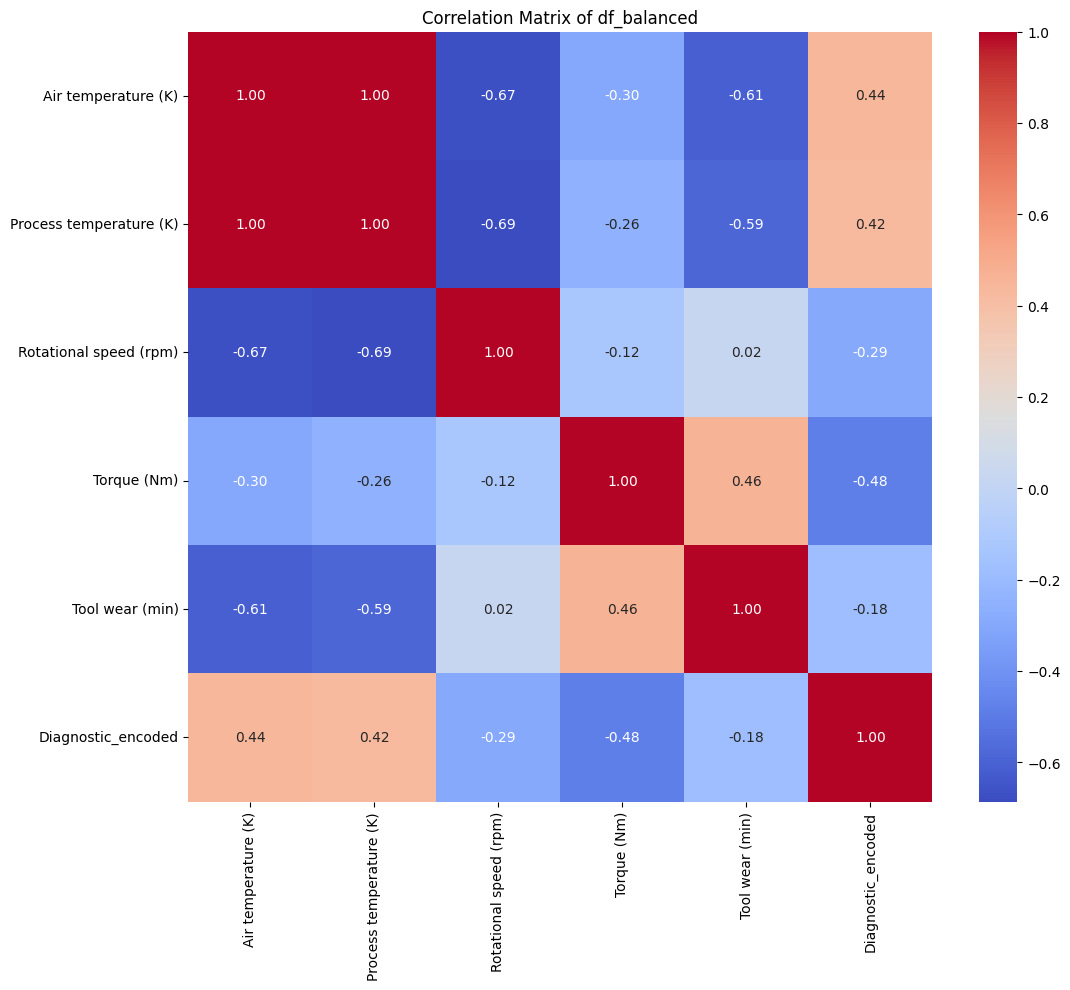

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
df_balanced = df_balanced.drop(['UDI','System'], axis=1) #Removed UDI and System as they were irrelevant.
# Calculate the correlation matrix
correlation_matrix = df_balanced.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of df_balanced')
plt.show()

In [11]:
def calculate_iqr_outliers(df):
  """
  Calculates the IQR and counts outliers for numerical features in a DataFrame.

  Args:
    df: The DataFrame to analyze.

  Returns:
    A dictionary with feature names as keys and a tuple of (IQR, outlier_count) as values.
  """
  outlier_info = {}
  for column in df.select_dtypes(include=['number']).columns:
    if column != 'Diagnostic_encoded':  # Exclude the target variable
      Q1 = df[column].quantile(0.25)
      Q3 = df[column].quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      outlier_count = len(df[(df[column] < lower_bound) | (df[column] > upper_bound)])
      outlier_info[column] = (IQR, outlier_count)
  return outlier_info

# Calculate IQR and outlier counts for df_balanced
outlier_counts_df_balanced = calculate_iqr_outliers(df_balanced)


# Print the results
for feature, (IQR, outlier_count) in outlier_counts_df_balanced.items():
  print(f"Feature: {feature}, IQR: {IQR:.2f}, Outlier Count: {outlier_count}")

Feature: Air temperature (K), IQR: 150.00, Outlier Count: 0
Feature: Process temperature (K), IQR: 150.00, Outlier Count: 0
Feature: Rotational speed (rpm), IQR: 727.00, Outlier Count: 9595
Feature: Torque (Nm), IQR: 40.98, Outlier Count: 0
Feature: Tool wear (min), IQR: 104.24, Outlier Count: 6603


In [12]:
# Define the IQR range
Q1 = df_balanced[['Rotational speed (rpm)', 'Tool wear (min)']].quantile(0.25)
Q3 = df_balanced[['Rotational speed (rpm)', 'Tool wear (min)']].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
df_balanced = df_balanced[
    (df_balanced['Rotational speed (rpm)'] >= lower_bound['Rotational speed (rpm)']) &
    (df_balanced['Rotational speed (rpm)'] <= upper_bound['Rotational speed (rpm)']) &
    (df_balanced['Tool wear (min)'] >= lower_bound['Tool wear (min)']) &
    (df_balanced['Tool wear (min)'] <= upper_bound['Tool wear (min)'])
]

print(f"New dataset shape after outlier removal: {df_balanced.shape}")

New dataset shape after outlier removal: (41829, 6)


In [13]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df_balanced.drop(columns=['Diagnostic_encoded'])
y = df_balanced['Diagnostic_encoded']

# Split into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shape of the splits
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (33463, 5), Test set: (8366, 5)


In [14]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
X_train.head()

,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min)
30461,250.0,250.0,2647.744654,10.735156,300.0
38166,250.0,250.0,1344.029670,67.110672,300.0
869,295.8,306.5,1358.000000,100.000000,300.0
5710,250.0,250.0,1413.000000,46.500000,300.0
35756,250.0,250.0,1431.867811,60.371704,300.0


In [15]:
pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [16]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

# Initialize the TabNet model
tabnet_model = TabNetClassifier(
    n_d=8,               # Dimension of the prediction layer
    n_a=8,               # Dimension of the attention layer
    n_steps=3,           # Number of steps in the architecture
    gamma=1.3,           # Scaling factor for attention updates
    lambda_sparse=1e-3,  # Sparsity regularization
    optimizer_params=dict(lr=2e-2),  # Optimizer parameters
    scheduler_params={"step_size":10, "gamma":0.9},  # Scheduler parameters
    scheduler_fn=torch.optim.lr_scheduler.StepLR,  # Learning rate scheduler
    mask_type='entmax'   # Masking function
)
# Train the model
tabnet_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_name=['test'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74922 | test_accuracy: 0.89864 |  0:00:04s
epoch 1  | loss: 0.20726 | test_accuracy: 0.96235 |  0:00:07s
epoch 2  | loss: 0.13718 | test_accuracy: 0.89481 |  0:00:09s
epoch 3  | loss: 0.12599 | test_accuracy: 0.72436 |  0:00:10s
epoch 4  | loss: 0.1093  | test_accuracy: 0.81329 |  0:00:13s
epoch 5  | loss: 0.09775 | test_accuracy: 0.91131 |  0:00:15s
epoch 6  | loss: 0.08907 | test_accuracy: 0.86493 |  0:00:17s
epoch 7  | loss: 0.08808 | test_accuracy: 0.96354 |  0:00:18s
epoch 8  | loss: 0.0892  | test_accuracy: 0.97071 |  0:00:20s
epoch 9  | loss: 0.08763 | test_accuracy: 0.97215 |  0:00:22s
epoch 10 | loss: 0.08461 | test_accuracy: 0.96354 |  0:00:24s
epoch 11 | loss: 0.07929 | test_accuracy: 0.97227 |  0:00:26s
epoch 12 | loss: 0.08169 | test_accuracy: 0.64595 |  0:00:28s
epoch 13 | loss: 0.0817  | test_accuracy: 0.93784 |  0:00:30s
epoch 14 | loss: 0.07427 | test_accuracy: 0.77767 |  0:00:32s
epoch 15 | loss: 0.07357 | test_accuracy: 0.82118 |  0:00:33s
epoch 16

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [17]:
from xgboost import XGBClassifier

# Initialize the XGBoost model
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=6,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Get training accuracy
train_accuracy = xgb_model.score(X_train_scaled, y_train)

# Print the training accuracy
print(f"Training Accuracy: {train_accuracy}")

Training Accuracy: 0.9950094133819443


In [18]:
# Predict on the test set
y_pred_tabnet = tabnet_model.predict(X_test_scaled)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

print("TabNet Model Accuracy:", accuracy_score(y_test, y_pred_tabnet))
print("Classification Report:\n", classification_report(y_test, y_pred_tabnet))

TabNet Model Accuracy: 0.9722687066698542
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.88      0.90      1186
         1.0       0.99      0.99      0.99      1931
         2.0       1.00      1.00      1.00       500
         3.0       0.99      1.00      1.00      1720
         4.0       0.92      0.94      0.93      1099
         5.0       0.99      1.00      1.00      1930

    accuracy                           0.97      8366
   macro avg       0.97      0.97      0.97      8366
weighted avg       0.97      0.97      0.97      8366



In [19]:
# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate the model
print("XGBoost Model Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Model Accuracy: 0.9904374850585704
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.95      0.97      1186
         1.0       1.00      1.00      1.00      1931
         2.0       1.00      1.00      1.00       500
         3.0       0.99      1.00      1.00      1720
         4.0       0.97      0.98      0.98      1099
         5.0       0.99      1.00      1.00      1930

    accuracy                           0.99      8366
   macro avg       0.99      0.99      0.99      8366
weighted avg       0.99      0.99      0.99      8366



In [20]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Obtain probabilistic predictions from each model
# TabNet predictions (assuming tabnet_model is already trained)
y_proba_tabnet = tabnet_model.predict_proba(X_test_scaled)

# XGBoost predictions (assuming xgb_model is already trained)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)

# Step 2: Assign fixed weights
weight_tabnet = 0.7
weight_xgb = 0.3

# Step 3: Compute weighted average of predictions
y_proba_ensemble = (weight_tabnet * y_proba_tabnet) + (weight_xgb * y_proba_xgb)

# Step 4: Make final predictions
y_pred_ensemble = np.argmax(y_proba_ensemble, axis=1)

# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))

Ensemble Model Accuracy: 0.9790
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.90      0.93      1186
         1.0       0.99      1.00      0.99      1931
         2.0       1.00      1.00      1.00       500
         3.0       0.99      1.00      1.00      1720
         4.0       0.93      0.94      0.94      1099
         5.0       0.99      1.00      1.00      1930

    accuracy                           0.98      8366
   macro avg       0.98      0.97      0.98      8366
weighted avg       0.98      0.98      0.98      8366



In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

class NativeSparseAttention(nn.Module):
    def __init__(self, dim, num_heads):
        super(NativeSparseAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        assert self.head_dim * num_heads == dim, "dim must be divisible by num_heads"

        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.proj = nn.Linear(dim, dim)

        # Sparse attention parameters
        self.dropout = nn.Dropout(0.1)
        self.scale = self.head_dim ** -0.5

    def forward(self, x):
        batch_size, seq_len, dim = x.size()

        # Project queries, keys, and values
        q = self.query(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = self.key(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.value(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale

        # Apply sparse mask (keeping only top-k values per row)
        k = min(int(seq_len * 0.3), seq_len)  # Keep top 30% of values
        topk_values, topk_indices = torch.topk(scores, k, dim=-1)
        sparse_scores = torch.zeros_like(scores).scatter_(-1, topk_indices, topk_values)

        # Apply softmax and dropout
        attn = F.softmax(sparse_scores, dim=-1)
        attn = self.dropout(attn)

        # Apply attention to values
        out = torch.matmul(attn, v).permute(0, 2, 1, 3).reshape(batch_size, seq_len, dim)
        out = self.proj(out)

        return out

class NSALayer(nn.Module):
    def __init__(self, dim, num_heads):
        super(NSALayer, self).__init__()
        self.attention = NativeSparseAttention(dim, num_heads)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim)
        )
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # Attention block
        attn_output = self.attention(x)
        x = self.norm1(x + attn_output)

        # Feed-forward block
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))

        return x

class TabNSA(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, num_heads=4, num_layers=3):
        super(TabNSA, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Input embedding
        self.embedding = nn.Linear(input_dim, hidden_dim)

        # NSA layers
        self.nsa_layers = nn.ModuleList([NSALayer(hidden_dim, num_heads) for _ in range(num_layers)])

        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Reshape input to add sequence dimension if it's just (batch_size, features)
        if len(x.shape) == 2:
            x = x.unsqueeze(1)  # (batch_size, 1, features)

        # Embed input features
        x = self.embedding(x)

        # Apply NSA layers
        for layer in self.nsa_layers:
            x = layer(x)

        # Take the output of the last position
        x = x.squeeze(1) if x.size(1) == 1 else x.mean(dim=1)

        # Classification head
        x = self.fc(x)

        return x


In [62]:
def prepare_data(X_train_scaled, y_train_scaled, batch_size=32, test_size=0.2, random_state=42):
    # # Split the data into training and validation sets
    # X_train_split, X_val, y_train_split, y_val = train_test_split(
    #     X_train_scaled, y_train_, test_size=test_size, random_state=random_state, stratify=y_train
    # )

    # # Scale the features
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train_split)
    # X_val_scaled = scaler.transform(X_val)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train.values)
    X_val_tensor = torch.FloatTensor(X_test_scaled)
    y_val_tensor = torch.LongTensor(y_test.values)

    # Create DataLoader objects
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader, scaler

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=100, patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total

        # Print statistics
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        # Save statistics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_tabnsa_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    return model, history

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Statistics
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_correct / test_total

    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

    return test_loss, test_acc, all_preds, all_targets


In [68]:
def main(X_train, y_train):
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Hyperparameters
    input_dim = X_train.shape[1]
    output_dim = 6  # Number of classes (0-5)
    hidden_dim = 64
    num_heads = 4
    num_layers = 3
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 5 #Yo

    # Prepare data
    train_loader, val_loader, scaler = prepare_data(X_train, y_train, batch_size=batch_size)

    # Initialize model
    model = TabNSA(
        input_dim=input_dim,
        output_dim=output_dim,
        hidden_dim=hidden_dim,
        num_heads=num_heads,
        num_layers=num_layers
    ).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs
    )

    # Load the best model
    model.load_state_dict(torch.load('best_tabnsa_model.pth'))

    # Evaluate on validation set
    val_loss, val_acc, val_preds, val_targets = evaluate_model(
        model=model,
        test_loader=val_loader,
        criterion=criterion,
        device=device
    )

    print(f"Final validation accuracy: {val_acc:.4f}")

    return model, scaler, history

# model, scaler, history = main(X_train, y_train)


In [69]:
# Train the model
model, scaler, history = main(X_train_scaled, y_train)

Using device: cpu
Epoch 1/5 | Train Loss: 0.2409 | Train Acc: 0.9251 | Val Loss: 0.1746 | Val Acc: 0.9478
Epoch 2/5 | Train Loss: 0.1508 | Train Acc: 0.9523 | Val Loss: 0.1956 | Val Acc: 0.9361
Epoch 3/5 | Train Loss: 0.1354 | Train Acc: 0.9579 | Val Loss: 0.1216 | Val Acc: 0.9616
Epoch 4/5 | Train Loss: 0.1242 | Train Acc: 0.9601 | Val Loss: 0.1032 | Val Acc: 0.9656
Epoch 5/5 | Train Loss: 0.1499 | Train Acc: 0.9522 | Val Loss: 0.1175 | Val Acc: 0.9600
Test Loss: 0.1032 | Test Acc: 0.9656
Final validation accuracy: 0.9656


In [79]:
def test_model(model, X_test_scaled, y_test, batch_size=64):
    # Convert to PyTorch tensors
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.LongTensor(y_test.values)

    # Create test DataLoader
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Set model to evaluation mode
    model.eval()

    # Initialize metrics
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_targets = []

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Calculate statistics
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

            # Store predictions and targets for further analysis
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate final metrics
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_correct / test_total

    print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}')

    return test_loss, test_acc, all_preds, all_targets

# Load the best model
model_path = 'best_tabnsa_model.pth'
input_dim = X_test_scaled.shape[1]
output_dim = 6  # Number of classes (0-5)
hidden_dim = 64
num_heads = 4
num_layers = 3

# Initialize model with same architecture
model = TabNSA(
    input_dim=input_dim,
    output_dim=output_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers
)

# Load the saved weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)

# Test the model
test_loss, test_acc, test_preds, test_targets = test_model(model, X_test_scaled, y_test)

# Optional: You can add more detailed evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(test_targets, test_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(test_targets, test_preds))


Test Loss: 0.1032 | Test Accuracy: 0.9656

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      1186
           1       0.95      1.00      0.98      1931
           2       1.00      1.00      1.00       500
           3       1.00      1.00      1.00      1720
           4       0.91      0.94      0.93      1099
           5       0.99      1.00      0.99      1930

    accuracy                           0.97      8366
   macro avg       0.96      0.96      0.96      8366
weighted avg       0.97      0.97      0.96      8366


Confusion Matrix:
[[ 962   99    1    8  103   13]
 [   0 1931    0    0    0    0]
 [   0    0  500    0    0    0]
 [   0    0    0 1720    0    0]
 [  57    0    0    0 1035    7]
 [   0    0    0    0    0 1930]]


In [80]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import torch

# Step 1: Obtain probabilistic predictions from each model
# TabNet predictions (assuming tabnet_model is already trained)
y_proba_tabnet = tabnet_model.predict_proba(X_test_scaled)

# Load the trained TabNSA model
input_dim = X_test_scaled.shape[1]
output_dim = 6  # Number of classes (0-5)
hidden_dim = 64
num_heads = 4
num_layers = 3

# Initialize the model with the same architecture
tabnsa_model = TabNSA(
    input_dim=input_dim,
    output_dim=output_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers
)

# Load the saved weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tabnsa_model.load_state_dict(torch.load('best_tabnsa_model.pth', map_location=device))
tabnsa_model = tabnsa_model.to(device)
tabnsa_model.eval()

# Get TabNSA predictions
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
with torch.no_grad():
    outputs = tabnsa_model(X_test_tensor)
    y_proba_tabnsa = torch.softmax(outputs, dim=1).cpu().numpy()

# Step 2: Assign fixed weights
weight_tabnet = 0.7
weight_tabnsa = 0.3

# Step 3: Compute weighted average of predictions
y_proba_ensemble = (weight_tabnet * y_proba_tabnet) + (weight_tabnsa * y_proba_tabnsa)

# Step 4: Make final predictions
y_pred_ensemble = np.argmax(y_proba_ensemble, axis=1)

# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))


Ensemble Model Accuracy: 0.9749
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91      1186
         1.0       0.98      1.00      0.99      1931
         2.0       1.00      1.00      1.00       500
         3.0       0.99      1.00      1.00      1720
         4.0       0.92      0.94      0.93      1099
         5.0       0.99      1.00      1.00      1930

    accuracy                           0.97      8366
   macro avg       0.97      0.97      0.97      8366
weighted avg       0.97      0.97      0.97      8366

